<a href="https://colab.research.google.com/github/Vineet2107/EEG_Pipeline/blob/main/Processing_EEG_dataset_with_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing and Visualising the Dataset

In [3]:
data = pd.read_csv('/content/drive/MyDrive/emotions.csv')

In [4]:
data

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,2.15,29.5,-353.0,14.40,21.5,5.98,30.7,-343.0,14.70,27.9,3.170,32.2,-368.0,15.90,36.4,7.08,28.8,-359.0,17.30,19.6,-3.8300,-1.230,-10.80000,-0.363,-6.41,-1.03,-2.780,14.600,-1.540,-14.900000,...,30.90,-24.4,-24.4,30.90,-442.0,388.0,-197.0,-197.0,388.0,-564.0,500.00,-245.00,-245.00,500.00,-88.8,214.0,-88.8,-88.8,214.0,-606.0,509.000,-261.0,-261.0,509.000,-399.0,374.00,-185.00,-185.00,374.00,74.3,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,25.60,32.8,29.6,21.50,17.4,25.50,31.7,31.5,26.20,32.9,31.800,33.1,33.2,28.50,26.8,32.40,34.7,33.8,27.00,14.2,0.0342,1.100,-1.87000,-4.690,-15.40,-6.22,-0.328,-3.530,-6.980,-9.370000,...,-5.99,-19.1,-19.1,-5.99,163.0,-11.0,-10.7,-10.7,-11.0,117.0,-3.93,17.90,17.90,-3.93,112.0,-13.9,25.5,25.5,-13.9,225.0,-0.968,-27.7,-27.7,-0.968,97.4,-19.00,40.70,40.70,-19.00,130.0,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,7.75,30.1,-441.0,9.89,25.3,-68.90,25.3,-481.0,-65.40,20.0,79.800,31.0,-408.0,91.90,29.5,18.80,31.1,-335.0,32.20,19.9,76.6000,4.850,39.90000,75.300,5.27,-72.00,-0.843,-33.000,-82.000,-4.200000,...,585.00,-285.0,-285.0,585.00,-94.3,183.0,-110.0,-110.0,183.0,-133.0,200.00,-72.00,-72.00,200.00,-356.0,295.0,-158.0,-158.0,295.0,-251.0,255.000,-95.7,-95.7,255.000,-177.0,159.00,-48.80,-48.80,159.00,-534.0,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,17.30,32.0,-148.0,20.40,22.8,13.20,31.5,-147.0,16.90,27.7,15.700,30.7,-142.0,20.70,22.8,13.60,32.2,-135.0,21.20,23.8,4.1500,0.556,-0.35400,3.460,-4.96,1.63,1.330,-5.830,-0.298,0.000777,...,249.00,-146.0,-146.0,249.00,359.0,-146.0,13.7,13.7,-146.0,119.0,-7.64,-7.17,-7.17,-7.64,-296.0,316.0,-218.0,-218.0,316.0,322.0,-113.000,38.4,38.4,-113.000,245.0,-61.90,-5.08,-5.08,-61.90,-183.0,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,26.10,34.3,43.7,23.70,20.6,-3.87,34.1,43.7,-10.00,22.9,59.400,26.7,60.3,64.70,26.9,32.30,30.1,33.6,31.60,27.7,30.0000,0.276,-0.00677,33.700,-2.36,-33.30,7.640,-16.600,-41.100,-6.290000,...,18.30,-11.9,-11.9,18.30,159.0,-18.2,-25.6,-25.6,-18.2,194.0,32.70,-54.50,-54.50,32.70,154.0,26.4,-56.4,-56.4,26.4,252.0,9.940,-37.4,-37.4,9.940,172.0,15.90,-7.25,-7.25,15.90,114.0,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,33.30,33.4,31.0,32.30,18.6,30.00,33.0,32.6,29.50,29.1,32.000,29.9,32.6,28.50,24.9,34.50,32.4,32.4,33.00,20.8,3.3500,0.461,-1.61000,2.880,-10.60,1.31,3.490,-1.540,3.860

In [5]:
data['label'].value_counts()

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

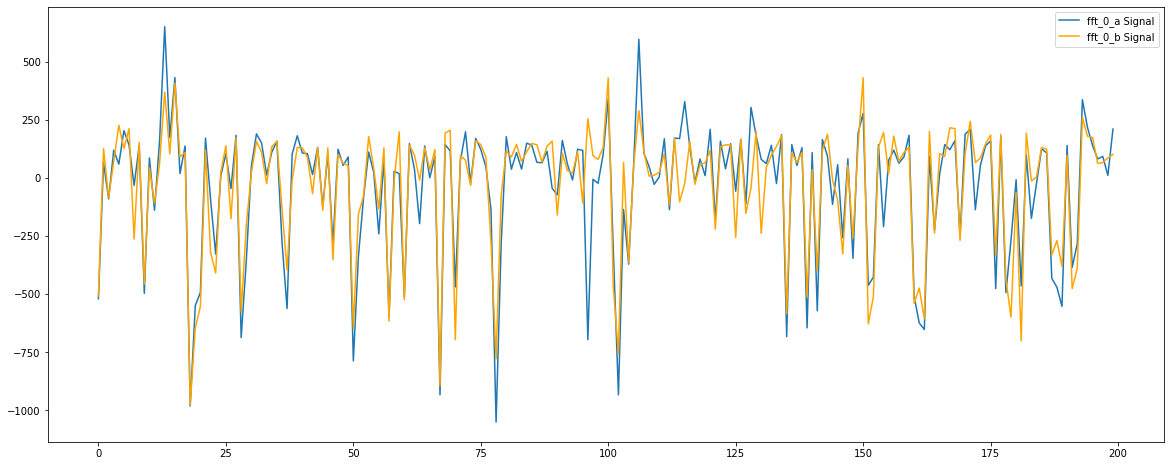

In [6]:
plt.figure(figsize=(20,8))
plt.plot(data['fft_0_a'][:200])
plt.plot(data['fft_0_b'][:200], 'orange')
plt.legend(['fft_0_a Signal', 'fft_0_b Signal'])

# Applying Preprocessing

In [7]:
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

In [8]:

def preprocess_inputs(df):
  df = df.copy()
    
  df['label'] = df['label'].replace(label_mapping)
    
  y = df['label'].copy()
  X = df.drop('label', axis=1).copy()
    
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
  return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [10]:
X_train

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_710_b,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
993,14.400,29.7,-112.0,18.50,22.9,-3.63000,-2.2200,-2.180,-3.240,-4.040,17.700,31.1,-101.0,20.40,27.7,14.700,30.6,-120.0,20.00,22.3,5.45,27.1,-120.0,13.70,19.8,19.500,30.1,-106.0,20.10,21.9,3.020,0.4640,18.900,0.3540,5.38,12.30,3.990,18.90,6.67,7.8200,...,-202.0,174.00,-89.900,-89.900,174.00,148.0,25.00,-29.80,-29.80,25.00,269.000,-103.00,63.50,63.50,-103.00,-71.2,85.60,-61.30,-61.30,85.60,29.8,107.0,-68.40,-68.40,107.0,269.0,28.40,-58.30,-58.30,28.40,-50.0,150.00,-150.00,-150.00,150.00,63.6,83.80,-40.90,-40.90,83.80
1851,13.700,22.8,21.5,8.40,27.1,3.27000,1.1200,6.480,2.300,5.660,13.300,22.2,16.0,7.73,25.8,10.800,22.3,20.4,6.78,22.8,15.20,26.0,20.4,9.75,28.9,15.500,20.8,29.0,9.36,31.0,2.550,-0.0606,-4.470,0.9500,3.00,-1.83,-3.760,-4.40,-2.02,-3.0700,...,178.0,-60.50,-0.106,-0.106,-60.50,124.0,-57.90,26.10,26.10,-57.90,163.000,-36.70,17.90,17.90,-36.70,138.0,-54.70,-66.90,-66.90,-54.70,68.6,-46.5,-58.00,-58.00,-46.5,160.0,-38.90,-3.29,-3.29,-38.90,74.2,-76.00,-10.90,-10.90,-76.00,60.9,-60.40,-31.40,-31.40,-60.40
1253,-0.765,24.7,-578.0,11.90,27.9,-1.44000,-4.2000,-8.310,-4.340,4.040,-0.199,29.3,-580.0,15.10,24.1,0.109,24.5,-569.0,13.10,27.6,1.79,22.6,-559.0,11.10,38.0,-4.680,22.7,-606.0,8.42,22.0,-0.308,4.7800,-11.300,2.0100,-3.48,-1.99,6.680,-21.00,3.99,-13.9000,...,-873.0,653.00,-355.000,-355.000,653.00,-571.0,634.00,-289.00,-289.00,634.00,-41.000,158.00,-50.50,-50.50,158.00,-719.0,566.00,-342.00,-342.00,566.00,-680.0,685.0,-317.00,-317.00,685.0,-112.0,235.00,-71.00,-71.00,235.00,-803.0,619.00,-331.00,-331.00,619.00,-551.0,545.00,-261.00,-261.00,545.00
1228,28.200,32.6,32.1,30.30,24.6,-0.00524,-0.0699,1.680,0.266,-4.470,25.700,33.2,27.5,27.10,30.0,30.600,32.1,34.9,33.10,23.7,28.40,33.8,32.9,30.30,21.1,28.000,31.4,33.0,30.60,23.5,-4.860,1.1300,-7.380,-5.9600,6.26,-2.70,-0.581,-5.35,-3.13,8.8800,...,155.0,-9.87,-28.400,-28.400,-9.87,136.0,2.17,-1.11,-1.11,2.17,48.200,-12.60,53.00,53.00,-12.60,206.0,-4.30,-55.10,-55.10,-4.30,168.0,18.9,-37.20,-37.20,18.9,131.0,9.69,10.90,10.90,9.69,167.0,-24.40,-18.10,-18.10,-24.40,181.0,4.94,-8.33,-8.33,4.94
1461,31.900,31.0,34.4,30.80,24.0,-4.74000,-1.4000,-0.351,-1.830,-5.390,32.700,29.9,34.9,31.80,32.5,35.800,33.4,34.3,31.70,21.0,27.00,32.0,32.3,27.50,23.8,31.900,28.5,36.1,32.30,18.9,-3.170,-3.5500,0.668,0.0455,11.60,5.63,-2.180,2.60,4.31,8.7400,...,131.0,-9.38,-7.340,-7.340,-9.38,126.0,-14.00,41.30,41.30,-14.00,124.000,-13.80,16.70,16.70,-13.80,157.0,-17.10,-7.39,-7.39,-17.10,129.0,-14.5,12.00,12.00,-14.5,112.0,-23.40,41.60,41.60,-23.40,130.0,-25.70,4.10,4.10,-25.70,131.0,-21.70,19.60,19.60,-21.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,6.820,32.9,-741.0,32.60,27.0,-0.41300,-2.6300,-87.300,-26.200,-3.350,8.190,33.9,-662.0,59.30,34.3,5.890,34.5,-732.0,32.50,23.2,5.86,31.5,-766.0,19.00,23.5,7.350,31.6,-803.0,20.10,27.1,2.300,-0.6200,70.100,26.8000,11.10,2.34,

#Model Architecture

In [11]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))
expand_dims = tf.expand_dims(inputs, axis=2)
lstm = tf.keras.layers.LSTM(256, return_sequences=True)(expand_dims)
flatten = tf.keras.layers.Flatten()(lstm)

outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2548)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 2548, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 2548, 256)         264192    
_________________________________________________________________
flatten (Flatten)            (None, 652288)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1956867   
Total params: 2,221,059
Trainable params: 2,221,059
Non-trainable params: 0
_________________________________________________________________
None


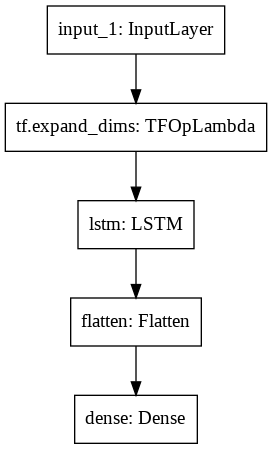

In [12]:
tf.keras.utils.plot_model(model, to_file = 'model.png')

In [13]:
modelSavingPath = 'modelSavingPath/checkpoint_{epoch:02d}'

earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.005, patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = modelSavingPath,
    verbose = 1,
    save_weights_only = True,
    save_freq = 'epoch'
)

model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


## Training the Model

In [14]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[earlyStoppingCallback, checkpoint]
)

Epoch 1/10
38/38 [==============================] - 13s 149ms/step - loss: 15.1096 - accuracy: 0.8013 - val_loss: 9.4792 - val_accuracy: 0.8863

Epoch 00001: saving model to modelSavingPath/checkpoint_01
Epoch 2/10
38/38 [==============================] - 5s 134ms/step - loss: 2.4040 - accuracy: 0.9204 - val_loss: 0.8934 - val_accuracy: 0.9565

Epoch 00002: saving model to modelSavingPath/checkpoint_02
Epoch 3/10
38/38 [==============================] - 5s 133ms/step - loss: 0.4526 - accuracy: 0.9757 - val_loss: 0.9146 - val_accuracy: 0.9465

Epoch 00003: saving model to modelSavingPath/checkpoint_03
Epoch 4/10
38/38 [==============================] - 5s 134ms/step - loss: 1.4774 - accuracy: 0.9447 - val_loss: 11.1355 - val_accuracy: 0.8963

Epoch 00004: saving model to modelSavingPath/checkpoint_04
Epoch 5/10
38/38 [==============================] - 5s 134ms/step - loss: 1.5039 - accuracy: 0.9648 - val_loss: 0.8568 - val_accuracy: 0.9632

Epoch 00005: saving model to modelSavingPath/c

In [15]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 96.094%


## Plotting History

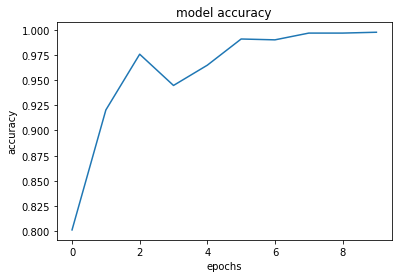

In [16]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

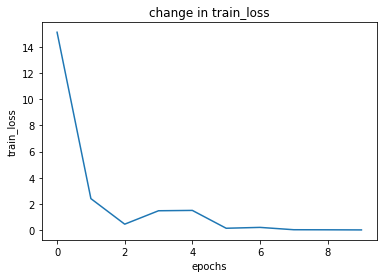

In [17]:
plt.plot(history.history['loss'])
plt.title('change in train_loss')
plt.ylabel('train_loss')
plt.xlabel('epochs')
plt.show()

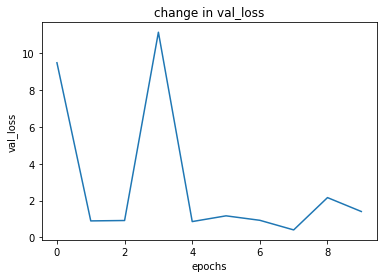

In [18]:
plt.plot(history.history['val_loss'])
plt.title('change in val_loss')
plt.ylabel('val_loss')
plt.xlabel('epochs')
plt.show()

## Confusion Matrix

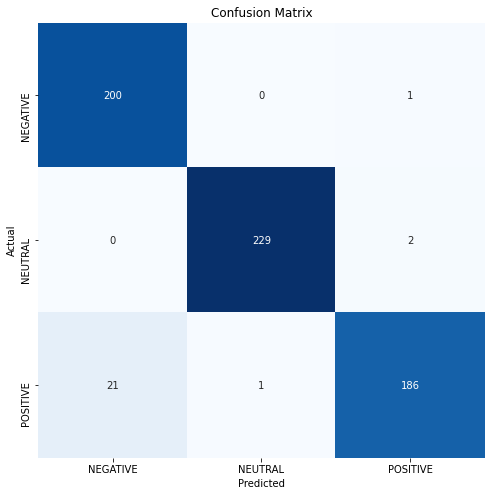

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.90      1.00      0.95       201
     NEUTRAL       1.00      0.99      0.99       231
    POSITIVE       0.98      0.89      0.94       208

    accuracy                           0.96       640
   macro avg       0.96      0.96      0.96       640
weighted avg       0.96      0.96      0.96       640



In [19]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", clr)